# Two-dimensional maps

In this notebook we extend our study of one-dimensional, discrete time maps from Notebook 1 to two dimensions. That is, we study maps of the form $f: X \to X$, where now $X$ is a subset of $\mathbb R^2$. Several of our coding constructs are either identical or minor modifications of the 1D case, so we do not provide detailed explanations here.  

In [1]:
%matplotlib ipympl

%load_ext nb_mypy
%nb_mypy On

Version 1.0.5


In [31]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np 

from fractions import Fraction
from itertools import accumulate, islice, repeat, zip_longest
from ipywidgets import interactive
from more_itertools import take
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from nptyping import Bool, Double, NDArray, Shape
from typing import Callable, Generator, Iterable, Iterator, List, TypeVar, Tuple

We represent the state space $X$ by a type variable `X` which is now a union of pairs of `float`s, pairs of `Fraction`s, `NDArray`s (whose first dimension has size 2), and `List`s of `NDArray`s. As in Notebook 1, we represent dynamical maps $f: X \to X$ by `Callable`s mapping `X` to `X`. We will also need a type variable `R` representing real numbers or lists of real numbers (e.g., parameters of our two-dimensional maps) and a type variable `B` representing Boolean variables or arrays of Boolean variables.

In [81]:
R = float | NDArray[Shape['*, ...'], Double]
X = Tuple[float, float] \
    | Tuple[Fraction, Fraction] \
    | NDArray[Shape['2, ...'], Double] \
    | List[NDArray[Shape['*, ...'], Double]] \
    | Tuple[NDArray[Shape['*, ...'], Double], NDArray[Shape['*, ...'], Double]]
F = Callable[[X], X]
B = bool | NDArray[Shape['*, ...'], Bool]

In the following, we define the identity map and a generator the computes orbits of points in an identical manner to Notebook 1.

In [71]:
def identity_map() -> F:
    f = lambda x: x
    return f


def orbit(x0: X, f: F) -> Generator[X, None, None]:
    """Orbit of a point under iterated application of a map."""
    x = x0
    while True:
        yield x
        x = f(x)

## Henon map

Our first example of a two-dimensional map is the _Henon map_, defined as $f(x,y) = (a - x^2 + by, x)$ for two real parameters $a, b$. We define a function `henon_map` that returns the Henon map given $a$ and $b$, as well as a helper function `in_henon_basin` used to estimate whether a given point lies in the basin of the Henon attractor. Function `gen_disc` generates an ensemble of initial conditions that sample a disc of specified center and radius.

In [72]:
def henon_map(a: R, b: R) -> F:
    f = lambda x: (a - x[0] ** 2 + b * x[1], x[0])
    return f


#def in_basin(a: R, b: R, n_check: int = 300, thresh: R = 5)\
def in_basin(f: F, n_check: int = 100, thresh: R = 5)\
    -> Callable[[X], B]:
    """Build function that tests whether a point lies in the basin of an 
    attractor under a 2D map.
    
    :f: Dynamical map.
    :n_int: Number of iterations before applying test.
    :thresh: Threshold radius used as a proxy for divergence to "infinity".
    :returns: Bool-valued function that tests whether a point x in R2 lies in
              the basin.
    
    """
    def ib(x: X) -> B:
        xn = list(islice(orbit(x, f), n_check, n_check + 1))
        result: B = abs(xn[0][0]) < thresh
        return result
    return ib


def gen_disc(c: Tuple[float, float], r: R, n: int) -> X:
    """Generate an ensemble of initial conditions in a disc in R2.
    
    :c: Coordinates of center of disc.
    :r: Disc radius.
    :n: Number of initial conditions.
    :returns: Tuple of x and y coordinates in the disc.
    
    """
    gx = np.linspace(c[0] - r, c[0] + r, num=n)
    gy = np.linspace(c[1] - r, c[1] + r, num=n)
    xs, ys = np.meshgrid(gx, gy)
    in_disc = (xs - c[0]) ** 2 + (ys - c[1]) ** 2 <= r ** 2
    xs = xs[in_disc]
    ys = ys[in_disc]
    return xs, ys        

### Qualitative behavior of orbits

We begin by examining orbits of points under the Henon map for different initial conditions and/or parameter values. Observe the period-2 sink for the default parameter values $a=1.25$ and $b=-0.3$. Use the sliders to explore how the qualitative behavior of the orbits changes as $a$ and $b$ are varied. What happens as 

interactive(children=(FloatSlider(value=1.25, description='a', max=1.5, min=1.0, step=0.01), FloatSlider(value…

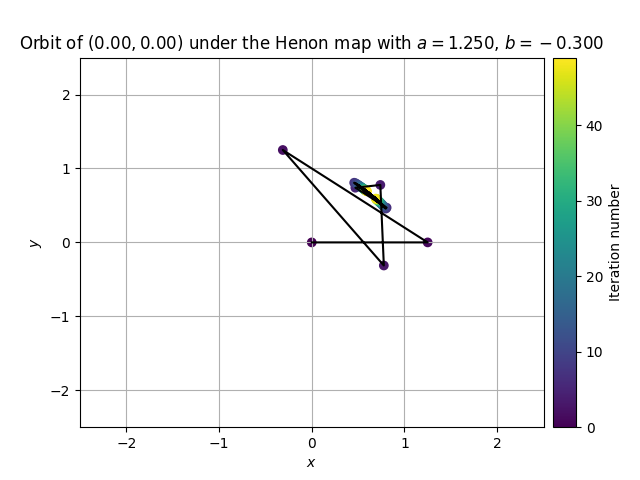

In [84]:
i_fig = 1
if plt.fignum_exists(i_fig):
    plt.close(i_fig)
fig, ax = plt.subplots(num=i_fig)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")


def plot_henon_orbit(a: R, b: R, x: float, y: float):
    """Helper function for plotting orbits of points under the Henon map. 
    
    :a: Henon map parameter a.
    :b: Henon map parameter b.
    :x: x xoordinate of the initial condition.
    :y: y coordinate of the initial condition.
    
    """
    n = 50 # number of iterations
    ks = range(n)
    x0 = (x, y)
    xs, ys = zip(*take(n, orbit(x0, henon_map(a, b))))
    ax.cla()
    ax.plot(xs, ys, 'k-')
    im = ax.scatter(xs, ys, c=ks)
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title(f'Orbit of $({x:.2f},{y:.2f})$ under the Henon map with $a={a:.3f}$, $b={b:.3f}$')
    ax.grid(True)
    fig.colorbar(im, cax=cax, label='Iteration number')
    
    
interactive(plot_henon_orbit, a=(1, 1.5, 0.01), b=-0.3, x=(-1, 1, 0.01),
            y=(-1, 1, 0.01))

Next, we examine the structure of the basin of the Henon attractor as a function of $a$ and $b$. The function `plot_henon_basis` plots, in blue color, points in the $(x,y)$ plane that lie in the basin of the Henon attractor according to the function `in_basin`. Use the sliders to visualize how the (estimated) basin changes as $a$ increases for fixed $b=-0.3$. 

interactive(children=(FloatSlider(value=1.25, description='a', max=1.5, min=1.0, step=0.01), FloatSlider(value…

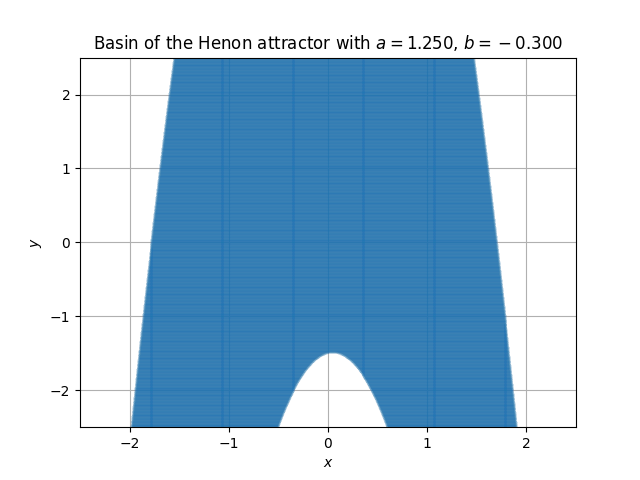

In [35]:
i_fig = 2
if plt.fignum_exists(i_fig):
    plt.close(i_fig)
fig, ax = plt.subplots(num=i_fig)


def plot_henon_basin(a: R, b: R):
    """Helper function to plot basin of the Henon attractor.
    
    :a: Henon map parameter a.
    :b: Henon map parameter b.
    
    """
    n_grid = 1000
    g = np.linspace(-2.5, 2.5, num=n_grid)
    xy = np.meshgrid(g, g)
    if_plt = in_basin(henon_map(a, b))
    ifxy = if_plt(xy)
    ax.cla()
    ax.plot(xy[0][ifxy], xy[1][ifxy], '.', markersize=0.1)
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title(f'Basin of the Henon attractor with $a={a:.3f}$, $b={b:.3f}$')
    ax.grid(True)
    
    
interactive(plot_henon_basin, a=(1, 1.5, 0.01), b=(-0.5, -0.1, 0.01))

### Bifurcation diagrams

Just as in the case of 1D maps, we can assess the behavior of the Henon map (as well as other 2D maps) under changes of parameters using bifurcation diagrams. The following figure shows a bifurcation diagram for the $x$ coordinate of the map as the parameter $a$ changes for fixed $b=0.4$. Notice the sequence of period-doubling bifurcations that resemble those we observed for the Logistic map in Notebook 1.

/var/folders/n4/mtx1vg0s385bvmyprx5vnzfh0000gn/T/ipykernel_96726/4169439486.py:2: RuntimeWarning: overflow encountered in square
  f = lambda x: (a - x[0] ** 2 + b * x[1], x[0])


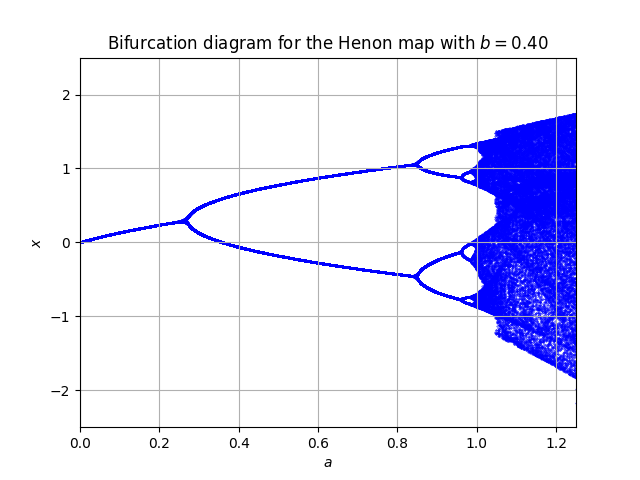

In [44]:
i_fig = 3
if plt.fignum_exists(i_fig):
    plt.close(i_fig)
fig, ax = plt.subplots(num=i_fig)


def plot_henon_bifurcation(a1: R, a2: R, b: R):
    """Helper function to plot bifurcation diagram for the Henon map.
    
    :a1: Lower limit for the a parameter.
    :a2: Upper limit for the a parameter.
    :b: Value of b parameter.
    
    """
    n_a = 1000 
    n_start = 101
    n_end = 300
    x0 = (0, 0)
    a = np.linspace(a1, a2, num=n_a) # generate an equispaced grid of evaluation points 
    orb = orbit(x0, henon_map(a, b))
    for xs in islice(orb, n_start, n_end):
        ax.scatter(a, xs[0], s=0.5, c='b', marker='.')
    ax.set_xlim(a1, a2)
    ax.set_ylim(-2.5, 2.5)
    ax.set_xlabel('$a$')
    ax.set_ylabel('$x$')
    ax.grid(True)
    ax.set_title(f'Bifurcation diagram for the Henon map with $b={b:.2f}$')

    
plot_henon_bifurcation(0, 1.25, 0.4)

### Visualizing the Henon attractor

To characterize the qualitative behavior of orbits under the Henon map, it is useful to identify sets in state space near which typical orbits settle after a sufficient number of iterations. Such sets are known as attractors. In the following figure, we plot approximations of the attractor under the Henon map as a function of the map parameters $a$ and $b$ by plotting the orbit of the origin, $(0, 0)$, after 100 iterations of the map. Use the sliders to visualize the changes in the structure of the attractor as the system undergoes the period-doubling bifurcations depicted in Figure 3.   

interactive(children=(FloatSlider(value=1.1, description='a', max=2.0, min=0.2, step=0.01), FloatSlider(value=…

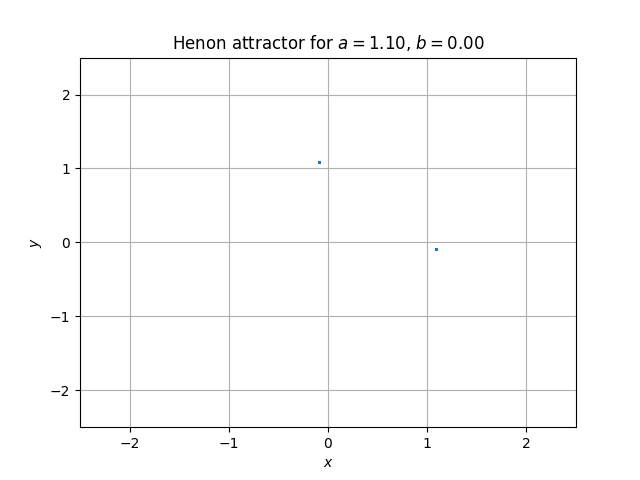

In [46]:
i_fig = 4
if plt.fignum_exists(i_fig):
    plt.close(i_fig)
fig, ax = plt.subplots(num=i_fig)


def plot_henon_attractor(a: R, b: R):
    """Helper function to plot points near the Henon attractor.
    
    :a: Henon map parameter a.
    :b: Hanon map parameter b.
    
    """
    n_start = 101
    n_end = 4101
    x0 = (0, 0)
    orb = orbit(x0, henon_map(a, b))
    xs, ys = zip(*islice(orb, n_start, n_end))
    ax.cla()
    ax.scatter(xs, ys, s=0.3, marker='o')
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.grid(True)
    ax.set_title(f'Henon attractor for $a={a:.2f}$, $b={b:.2f}$')

    
interactive(plot_henon_attractor, a=(0.2, 2, 0.01), b=(-0.5, 0.5, 0.01))

Finally, we examine the evolution of a disc centered at the saddle fixed point at $(-0.6, -0.6)$ that the Henon map has for the parameter values $a=0$ and $b=0.4$.

interactive(children=(IntSlider(value=2, description='k', max=5), Output()), _dom_classes=('widget-interact',)…

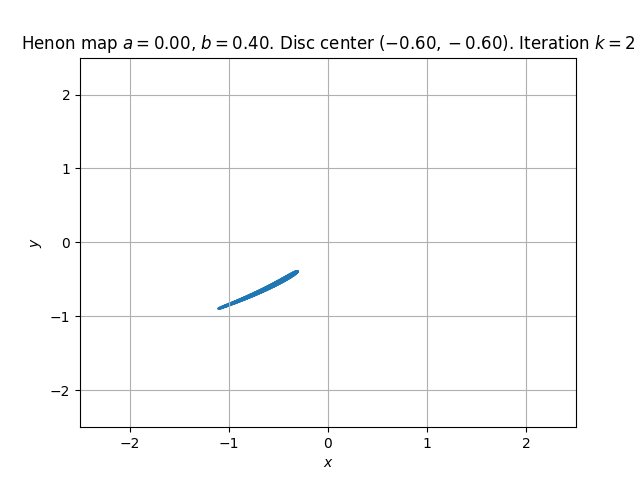

In [73]:
i_fig = 5
if plt.fignum_exists(i_fig):
    plt.close(i_fig)
fig, ax = plt.subplots(num=i_fig)


def plot_henon_disc(a: R, b: R, c: Tuple[float, float], r: R, k: int):
    """Helper function to plot the evolution of a disc of initial conditions
    under the Henon map.
    
    :a: Henon map parameter a.
    :b: Henon map parameter b.
    :c: Center of disc.
    :r: Disc radius.
    :k: Iteration number.
    
    """
    x0 = gen_disc(c, r, 100)
    orb = orbit(x0, henon_map(a, b))
    xs, ys = zip(*islice(orb, k, k + 1))
    ax.cla()
    ax.scatter(xs, ys, s=0.2, marker='o')
        
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.grid(True)
    ax.set_title(f'Henon map $a={a:.2f}$, $b={b:.2f}$. Disc center $({c[0]:.2f}, {c[1]:.2f})$. Iteration $k={k}$')

    
a = 0
b = 0.4
x = (-0.6,-0.6)
r = 0.2
interactive(lambda k: plot_henon_disc(a, b, x, r, k), k=(0, 5, 1)) 